In [132]:
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import skfuzzy as fuzz
from sklearn.metrics import fowlkes_mallows_score
import math

In [133]:
pd.options.display.max_rows = 6

ratings = pd.read_csv(Path('..','..','res','data','ratings.csv'))

users = pd.read_csv(Path('..','..','res','data','users.csv'))

movies = pd.read_csv(Path('..','..','res','data','movies.csv'))


# zmiana napisów na liczby
label_encoder = LabelEncoder()
users['gender'] = label_encoder.fit_transform(users['gender'])
users['occupation'] = label_encoder.fit_transform(users['occupation'])

In [137]:
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating')

train_set, test_set = train_test_split(ratings_matrix, test_size=0.2)#, random_state=42)
test_set = test_set.fillna(0)
train_set = train_set.fillna(0)
users_train = users[~users['user_id'].isin(test_set.index.to_list())]
items_train = ratings[~ratings['user_id'].isin(test_set.index.to_list())]

users_test = users[users['user_id'].isin(test_set.index.to_list())]
items_test = ratings[ratings['user_id'].isin(test_set.index.to_list())]

train_set.to_csv(Path('..','..','outputs','train_set.csv'), index = False)
test_set.to_csv(Path('..','..','outputs','test_set.csv'), index = False)

us_te_cl = users_test.copy()
us_te_cl['cluster'] = 1

us_tr_cl = users_train.copy()
us_tr_cl['cluster'] = 1

it_cl = items_train.copy()
it_cl['cluster'] = 1

"""it_cl = article_items_cl
it_cl"""

'it_cl = article_items_cl\nit_cl'

In [156]:
items_train

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
3,244,51,2,880606923
...,...,...,...,...
99995,880,476,3,880175444
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [135]:
train_set

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
794,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213,2.0,4.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,5.0,0.0,0.0,5.0,5.0,5.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
454,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
def cluster_items(items_info):
    data_to_cluster = items_info['rating'].to_numpy()
    data_to_cluster = data_to_cluster.reshape(-1,1)
    K_FCM = 100
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_to_cluster.T, K_FCM, 2, error=0.005, maxiter=1000)
    clusters = np.argmax(u, axis=0)
    items_info['cluster'] = clusters
    return(items_info)


def cluster_items2(items_info):
    data_to_cluster = items_info[['rating', 'user_id', 'movie_id']].to_numpy()
    print(items_info.shape, data_to_cluster.shape)
    data_to_cluster = data_to_cluster.reshape(-1,3)
    print(data_to_cluster.shape)
    K_FCM = 100
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data_to_cluster.T, K_FCM, 2, error=0.005, maxiter=1000)
    clusters = np.argmax(u, axis=0)
    print(len(clusters))
    items_info['cluster'] = clusters
    return(items_info)

cluster_items_3cols = cluster_items2(items_test)

(20950, 4) (20950, 3)
(20950, 3)
20950


C:\Users\wypyc\AppData\Local\Temp\ipykernel_20628\76798809.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_info['cluster'] = clusters


In [160]:
cluster_items_3cols.to_csv(Path('..','..','outputs','3columns_items.csv'))

In [139]:
def cluster_users(users_info):
    data_to_cluseter = users_info[['age','gender','occupation']]
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, verbose=1, random_state=42) 
    clusters = kmode.fit_predict(data_to_cluseter) 
    users_info['cluster'] = clusters
    return(users_info)

In [140]:
def IP(train_numpy, train_set):#, items_clustered):

    #obliczanie item popularity
    #szukanie IPmax
    IP = np.sum(train_numpy, axis = 0) #sumowanie po kolumnach
    IP = IP.reshape(1,-1)
    IPmax = np.amax(IP)
    IPmax_coordinates = np.argmax(IP) + 1 #bo filmy mają indeksy od 1
    item_rating = pd.DataFrame({'rating':IP[0], 'movie_id': train_set.columns.to_list()})
    ####
    #items_train = ratings[~ratings['user_id'].isin(test_set.index.to_list())]
    #items_clustered = cluster_items(item_rating)
    #items_clustered = items_clustered[items_clustered['rating'] > 0]
    items_clustered = it_cl
    #items_clustered.to_csv(Path('..','..','outputs','items_train_clustered22.csv'))
    #items_clustered = pd.read_csv(Path('..','..','outputs','jeden_cluster.csv'))
    IPmax_movie_id = item_rating[item_rating['rating'] == IPmax]['movie_id'].values[0]
    #print(items_clustered[items_clustered['movie_id'] > 0])
    ####
    #znalezienie clustra IPmax i należących do niego elementów
    IPmax_cluster = items_clustered[items_clustered['movie_id'] == IPmax_movie_id].iloc[0,4]

    max_clust_movies = items_clustered[items_clustered['cluster'] == IPmax_cluster]['movie_id'].to_list()
    max_clust_movies = list(set(max_clust_movies))
    IP_dash = IP[:,np.array(max_clust_movies) - 1] / IPmax
    return(IP_dash, max_clust_movies)

IP_dash_movies = IP(train_set.to_numpy(), train_set)
IP_dashhhh = IP_dash_movies[0]
IP_moviesss = IP_dash_movies[1]



In [141]:
#def UP_HP(train_test_set, cluster, clust_data, IP_dash, alpha, selected_movies, ratings_matrix):
def UP_HP(train_matrix, test_matrix, u_te_cl, u_tr_cl, cluster, IP_dash, alpha, selected_movies, ratings_matrix):    
    test_set_zero = test_matrix.copy()
    test_set_zero[:] = 0
    concated_users_clustered = pd.concat([us_tr_cl,us_te_cl], ignore_index=True).sort_values('user_id')
    train_and_test = pd.concat([train_matrix, test_set_zero], ignore_index=False)
    train_and_test = train_and_test.sort_index()

    ratings_matrix = ratings_matrix.fillna(0)

    #znalezienie starych użytkowników w danym clustrze
    users_in_cluster = concated_users_clustered[concated_users_clustered['cluster'] == cluster]['user_id'].to_list()
    users_in_cluster = list(set(users_in_cluster))
    #macierz ratingów tylko dla tych userów
    
    #ratings_matrix_cluster = train_set[train_set.index.isin(users_in_cluster)].to_numpy()
    ratings_matrix_cluster = train_and_test.loc[train_and_test.index.isin(users_in_cluster),selected_movies]
    ratings_matrix_clusterr = ratings_matrix_cluster.to_numpy()

    ratings_matrix_cluster_original = ratings_matrix.loc[ratings_matrix.index.isin(users_in_cluster),selected_movies].to_numpy()

    #obliczanie user popularity
    UP = np.sum(ratings_matrix_clusterr, axis=1) ##sumowanie po wierszach
    UP = UP.reshape(-1,1)
    UPmax = np.amax(UP)
    UPmax_coordinates = np.argmax(UP)
    UP_dash = UP / UPmax
    
    # obliczenie UIP i hybrydy
    UIP = UP_dash / IP_dash

    UIP = np.where(ratings_matrix_cluster == 0, 0, UIP)
    HP = alpha * IP_dash + (1-alpha) * np.sum(UIP,axis = 0).reshape(1,-1)
    return(HP)
    #return np.sum(pd.DataFrame(UIP, index=ratings_matrix_cluster.index, columns=ratings_matrix_cluster.columns).loc[243,9])

"""test_set_zero = test_set.copy()
test_set_zero[:] = 0
concated_users_clustered = pd.concat([us_tr_cl,us_te_cl], ignore_index=True).sort_values('user_id')
train_and_test = pd.concat([train_set, test_set_zero], ignore_index=False)
train_and_test = train_and_test.sort_index()"""

UP_HP(train_set, test_set, us_te_cl, us_tr_cl, 1, IP_dashhhh, 0.5, IP_moviesss, ratings_matrix)

array([[ 66.31241609, 136.29892908, 131.64251799, ...,  85.05144667,
        183.17435039, 181.1372018 ]])

In [142]:
def HP_for_clust(test_set, train_set, alpha, ratings_matrix, us_te_cl, us_tr_cl):
    
    #zastąpienie nan zerami
    train_set = train_set.fillna(0)
    train_set = train_set.sort_index()
    test_set = test_set.fillna(0)
    test_set = test_set.sort_index()

    train_numpy = train_set.to_numpy()
    test_numpy = test_set.to_numpy()

    #zbiory treningowe ####USUN###
    users_train = users[~users['user_id'].isin(test_set.index.to_list())]
    items_train = ratings[~ratings['user_id'].isin(test_set.index.to_list())]
    
    #zbiory testowe
    users_test = users[users['user_id'].isin(test_set.index.to_list())]
    items_test = ratings[ratings['user_id'].isin(test_set.index.to_list())]
    
    #podział na clustry
    #users_clustered = cluster_users(users_train.copy())
    #items_clustered = cluster_items(items_train.copy())
    
    """users_clustered = pd.read_csv(Path('..','..','outputs','users_train_clustered.csv'))
    #items_clustered = pd.read_csv(Path('..','..','outputs','items_train_clustered.csv'))
    users_clustered['cluster'] = 1
    #przypisanie nowych użytkowników do clustrów
    kmode = KModes(n_clusters=5, init = "random", n_init = 5, random_state = 42)#verbose=1, random_state=42) 
    train_clusters = kmode.fit_predict(users_train)
    test_users_clusters = kmode.predict(users_test)
    test_users_clustered = users_test.copy() ##OCEŃ CZY KOPIOWANIE JEST KONIECZNE
    test_users_clustered['cluster'] = test_users_clusters"""
    
    users_clustered = us_tr_cl
    test_users_clustered = us_te_cl
    test_users_clusters = test_users_clustered['cluster'].values
    IP_results = IP(train_numpy, train_set)
    IP_dash = IP_results[0]
    movies_from_max_cluster = IP_results[1]
    """clust_HP = {0:None,
                1:None,
                2:None,
                3:None,
                4:None}"""
    clust_HP = {}
    test_set_zero = test_set.copy()
    test_set_zero[:] = 0
    
    concated_users_clustered = pd.concat([users_clustered,test_users_clustered], ignore_index=True)
    train_and_test = pd.concat([train_set, test_set_zero], ignore_index=False)
    for cl in list(set(test_users_clusters)):
        HP = UP_HP(train_set, test_set, us_te_cl, us_tr_cl, cl, IP_dash, alpha, movies_from_max_cluster, ratings_matrix)[0].tolist()  
        clust_HP[cl] = (movies_from_max_cluster, HP)
    return(clust_HP, test_users_clustered) #słownik cluster: filmy z clustra gdzie IP_max, HP;
                                            #testoei uzytkownicy z wygenerowanymi klastrami
    #return(HP)
z = HP_for_clust(test_set, train_set, 0.5, ratings_matrix, us_te_cl, us_tr_cl)
len(z[0][1][0]) #długość movies_from_max_cluster
z[0][1][1][-3] #3 od konca wartość z HP

85.05144666888351

In [143]:
def create_matrix_for_generated(test_set, train_set, alpha, ratings_matrix, us_te_cl, us_tr_cl):
    HP_and_clust = HP_for_clust(test_set, train_set, alpha, ratings_matrix, us_te_cl, us_tr_cl)
    movies_and_HP = HP_and_clust[0] #słownik z filmy do polecenia i HP dla każdego clustra
    test_users_with_clusters = HP_and_clust[1]
    #print(test_users_with_clusters)   #dataframe
    num_users_in_clust = test_users_with_clusters.groupby('cluster').agg(users_number = ('cluster','size')).reset_index()
    #print(num_users_in_clust)  #dataframe z kolumna cluster i liczba
    users_per_cluster = test_users_with_clusters.groupby('cluster')['user_id'].apply(list).to_dict() #uzytkownicy (id) w kazdym clustrze
    #print(users_per_cluster)  #słownik
    num_users_per_cluster = num_users_in_clust.set_index('cluster')['users_number'].to_dict() #liczba użytkowników w każdym clustrze
    #print(num_users_per_cluster) #słownik
    test_users_dictionary = {'user_id':[],
                         'movie_id':[],
                         'rating':[]}
    
    for cl in users_per_cluster.keys():
        num_of_users = num_users_per_cluster[cl]
        num_of_items = len(movies_and_HP[cl][0])

        multiplied_users = users_per_cluster[cl] * num_of_items
        multiplied_users.sort()
        test_users_dictionary['user_id'].extend(multiplied_users)
        #aktualizuję uzytkowników w clustrze powielając ich tyle razy ile jest przedmiotów, 
        #bo każdy musi dany przedmiot mieć oceniony
        users_per_cluster[cl] = multiplied_users

        #powielam przedmioty i oceny tyle razy ilu jest użytkowników
        movies_and_HP[cl] = (movies_and_HP[cl][0] * num_of_users, movies_and_HP[cl][1] * num_of_users)
        test_users_dictionary['movie_id'].extend(movies_and_HP[cl][0])
        test_users_dictionary['rating'].extend(movies_and_HP[cl][1])

        test_ratings_HP = pd.DataFrame(test_users_dictionary)
        test_ratings_HP.to_csv(Path('..','..','outputs','test_ratings.csv'), index=False)
        test_ratings_matrix = test_ratings_HP.pivot(index='user_id', columns='movie_id', values='rating')
        test_ratings_matrix = test_ratings_matrix.fillna(0)
        HP_columns = test_ratings_matrix.columns
        print(HP_columns)

        test_set_limited = test_set[test_set.columns[test_set.columns.isin(HP_columns)]]
        test_set_limited = test_set_limited.fillna(0).sort_index()
        test_set_limited.to_csv(Path('..','..','outputs','test_set_limited.csv'), index=False)

    return test_ratings_matrix

create_matrix_for_generated(test_set, train_set, 0.5, ratings_matrix, us_te_cl, us_tr_cl)


Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       1671, 1672, 1673, 1674, 1677, 1678, 1679, 1680, 1681, 1682],
      dtype='int64', name='movie_id', length=1670)


movie_id,1,2,3,4,5,6,7,8,9,10,...,1671,1672,1673,1674,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
5,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,91.162646,274.76091,71.810227,103.768242,118.32512,170.102154,56.701375,85.051447,183.17435,181.137202
12,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,91.162646,274.76091,71.810227,103.768242,118.32512,170.102154,56.701375,85.051447,183.17435,181.137202
15,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,91.162646,274.76091,71.810227,103.768242,118.32512,170.102154,56.701375,85.051447,183.17435,181.137202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,91.162646,274.76091,71.810227,103.768242,118.32512,170.102154,56.701375,85.051447,183.17435,181.137202
934,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,91.162646,274.76091,71.810227,103.768242,118.32512,170.102154,56.701375,85.051447,183.17435,181.137202
939,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,91.162646,274.76091,71.810227,103.768242,118.32512,170.102154,56.701375,85.051447,183.17435,181.137202


In [144]:
def find_topN_items(users_ratings,N):
    original_indices = users_ratings.index #oryginalne indeksy
    print(min(users_ratings.index))
    topN = users_ratings.nlargest(N) #N najlepiej ocenianych filmów (rating i indeks) 
                                        #zwraca się od najwiekszej do najmn wartosci
    topN_indices = topN.index #indeksy tych najlepiej ocenianych
    
    zero_mask = users_ratings == 0 #maska do tych miejsc gdzie user_rating jest zero
    zero_indices = users_ratings[zero_mask].index #indeksy tego gdzie jest zero
    mask = users_ratings.index.isin(topN_indices) #maska na te ratingi i indeksy które wchodza w skład topN
    #users_ratings = pd.Series([0 for i in range(len(users_ratings))], index = original_indices)
    #users_ratings[mask] = 1
    #users_ratings[zero_indices] = 0
    #print(users_ratings[topN_indices][users_ratings[topN_indices]<5])
    top_nonzero_indices = users_ratings[topN_indices][users_ratings[topN_indices] > 0].index
    users_ratings["topN_movies"] = top_nonzero_indices.values
    return users_ratings

In [ ]:
#extract.apply(lambda row: find_topN_items(row, 20), axis = 1)
extract2 = output.iloc[:,0:1664]

extract2.apply(lambda row: find_topN_items(row, 20), axis = 1)

NameError: name 'output' is not defined

In [ ]:
dfk = pd.DataFrame(k)
print(dfk[0].nlargest(2))
ind = dfk[0].nlargest(2).index
dfk[dfk.index.isin(ind)]
extract2.iloc[1,:].nlargest(3)

3    40
2    15
Name: 0, dtype: int32


movie_id
1644    955.912085
830     945.354826
852     945.354826
Name: 3, dtype: float64

In [145]:
def show_Hu(row):
    """ wybieranie id filmów, dla których w zbiorze testowym użytkownik wystawił jakieś oceny"""
    nonzero = row[row > 0].index
    nonzero_indices = nonzero.values
    row['Hu'] = nonzero_indices.tolist()
    print(nonzero_indices.tolist())
    return row

In [146]:
def NDCG(row,N):
    generated = row.loc['topN_movies']
    from_test_set = row.loc['Hu']
    #sprawdzenie który n-ty element z TopN został irl oceniony przez użytkownika
    available_n = [index + 1  for index, element in enumerate(generated) if element in from_test_set]
    DCG = sum([1 / math.log(1+n,2) for n in available_n])
    IDCG = sum([math.log(1+n,2) for n in range(1,N+1)])
    NDCG = DCG / IDCG
    row['NDCG'] = NDCG
    return row

In [ ]:
extract = output.iloc[:,0:1666]
extract.apply(lambda row: NDCG(row, 20), axis = 1)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1676,1677,1678,1679,1680,1681,1682,topN_movies,Hu,NDCG
user_id,,,,,,,,,,,,,,,,,,,,,
2,66.287041,126.48051,122.839506,108.90073,117.717605,90.630449,70.807368,87.052041,68.996945,88.448736,...,173.475463,111.491805,160.27864,53.426879,80.139694,172.595941,170.67644,"[1644, 830, 852, 784, 599, 1486, 1493, 1494, 1...","[1, 10, 13, 14, 19, 25, 50, 100, 111, 127, 237...",0.0
3,66.287041,126.48051,122.839506,108.90073,117.717605,90.630449,70.807368,87.052041,68.996945,88.448736,...,173.475463,111.491805,160.27864,53.426879,80.139694,172.595941,170.67644,"[1644, 830, 852, 784, 599, 1486, 1493, 1494, 1...","[181, 245, 258, 260, 264, 268, 271, 272, 288, ...",0.0
6,66.287041,126.48051,122.839506,108.90073,117.717605,90.630449,70.807368,87.052041,68.996945,88.448736,...,173.475463,111.491805,160.27864,53.426879,80.139694,172.595941,170.67644,"[1644, 830, 852, 784, 599, 1486, 1493, 1494, 1...","[1, 7, 8, 9, 12, 13, 14, 15, 19, 21, 22, 23, 2...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,66.287041,126.48051,122.839506,108.90073,117.717605,90.630449,70.807368,87.052041,68.996945,88.448736,...,173.475463,111.491805,160.27864,53.426879,80.139694,172.595941,170.67644,"[1644, 830, 852, 784, 599, 1486, 1493, 1494, 1...","[1, 7, 9, 15, 25, 50, 100, 105, 106, 111, 117,...",0.0
940,66.287041,126.48051,122.839506,108.90073,117.717605,90.630449,70.807368,87.052041,68.996945,88.448736,...,173.475463,111.491805,160.27864,53.426879,80.139694,172.595941,170.67644,"[1644, 830, 852, 784, 599, 1486, 1493, 1494, 1...","[4, 7, 8, 9, 12, 14, 47, 50, 56, 66, 69, 70, 8...",0.0
941,66.287041,126.48051,122.839506,108.90073,117.717605,90.630449,70.807368,87.052041,68.996945,88.448736,...,173.475463,111.491805,160.27864,53.426879,80.139694,172.595941,170.67644,"[1644, 830, 852, 784, 599, 1486, 1493, 1494, 1...","[1, 7, 15, 117, 124, 147, 181, 222, 257, 258, ...",0.0


In [147]:
def Precision_Recall(row,N):
    generated = row.loc['topN_movies']
    print(row)
    from_test_set = row.loc['Hu']
    intersection = sum([1 for element in generated if element in from_test_set])
    
    Precision = intersection * 100 / N
    row['Precision'] = Precision
    
    row['Recall'] = intersection * 100 / len(from_test_set)
    return row

In [149]:
def nazwepozniej(test_set, train_set, alpha, N, ratings_matrix, us_te_cl, us_tr_cl):
    generated = create_matrix_for_generated(test_set, train_set, alpha, ratings_matrix, us_te_cl, us_tr_cl)
    test_set_with_Hu = test_set.apply(lambda row: show_Hu(row), axis = 1)
    generated_topN = generated.apply(lambda row: find_topN_items(row, N), axis = 1)
    Hu = test_set_with_Hu.iloc[:,[-1]].sort_index()
    Huu = Hu.iloc[:,[-1]].values
    """print(generated_topN.index)
    print(Hu_sorted.index)
    print(Hu_sorted['Hu'])"""
    #generated_topN['Hu'] = Huu[0]
    merged = pd.merge(generated_topN, Hu, on='user_id', how = 'left')
    merged = merged.apply(lambda row:  NDCG(row,N),axis = 1)
    merged = merged.apply(lambda row:  Precision_Recall(row,N),axis = 1)
    
    #return(merged)
    return(merged)
output_final = nazwepozniej(test_set, train_set, 0.5, 50, ratings_matrix, us_te_cl, us_tr_cl)

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       1671, 1672, 1673, 1674, 1677, 1678, 1679, 1680, 1681, 1682],
      dtype='int64', name='movie_id', length=1670)
[1, 7, 8, 10, 13, 14, 15, 16, 22, 25, 26, 28, 69, 77, 83, 86, 93, 111, 116, 125, 127, 129, 137, 151, 157, 162, 173, 191, 194, 196, 208, 215, 221, 223, 225, 237, 246, 268, 275, 280, 283, 285, 286, 306, 317, 318, 367, 387, 423, 435, 458, 461, 468, 477, 509, 511, 514, 531, 582, 631, 632, 655, 660, 694, 699, 708, 713, 724, 732, 736, 737, 778, 813, 1039, 1115, 1148, 1197, 1281, 1368, 1465, 1466]
[15, 22, 28, 50, 56, 82, 83, 95, 97, 98, 99, 111, 121, 132, 143, 144, 162, 164, 165, 166, 172, 173, 174, 191, 193, 198, 202, 204, 210, 213, 222, 230, 274, 275, 282, 283, 288, 294, 313, 318, 419, 423, 465, 478, 479, 482, 483, 485, 487, 496, 498, 582, 591, 603, 604, 605, 607, 662, 699, 705, 724, 742, 751, 821]
[3, 5, 7, 8, 9, 11, 13, 15, 17, 22, 23, 42, 44, 47, 48, 50, 51, 52, 53, 55, 56, 58, 59, 63, 64, 65,

In [153]:
output_final[output_final['NDCG'] > 0]

movie_id,1,2,3,4,5,6,7,8,9,10,...,1678,1679,1680,1681,1682,topN_movies,Hu,NDCG,Precision,Recall
user_id,,,,,,,,,,,,,,,,,,,,,
5,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,170.102154,56.701375,85.051447,183.17435,181.137202,"[830, 852, 784, 599, 1486, 1493, 1494, 1306, 1...","[1, 2, 17, 21, 24, 25, 29, 40, 42, 50, 62, 63,...",0.001633,4.0,1.142857
167,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,170.102154,56.701375,85.051447,183.17435,181.137202,"[830, 852, 784, 599, 1486, 1493, 1494, 1306, 1...","[8, 48, 73, 83, 86, 96, 99, 126, 133, 136, 137...",0.004962,8.0,5.797101
194,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,170.102154,56.701375,85.051447,183.17435,181.137202,"[830, 852, 784, 599, 1486, 1493, 1494, 1306, 1...","[1, 4, 7, 8, 9, 12, 13, 15, 22, 23, 25, 26, 28...",0.001269,2.0,0.327869
207,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,170.102154,56.701375,85.051447,183.17435,181.137202,"[830, 852, 784, 599, 1486, 1493, 1494, 1306, 1...","[2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 18, 22,...",0.000802,2.0,0.434783
456,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,170.102154,56.701375,85.051447,183.17435,181.137202,"[830, 852, 784, 599, 1486, 1493, 1494, 1306, 1...","[1, 3, 4, 9, 12, 13, 14, 22, 23, 32, 33, 42, 4...",0.001164,2.0,0.460829
622,66.312416,136.298929,131.642518,114.096568,125.261384,100.953128,72.065597,90.577031,69.566618,93.681167,...,170.102154,56.701375,85.051447,183.17435,181.137202,"[830, 852, 784, 599, 1486, 1493, 1494, 1306, 1...","[1, 2, 3, 4, 7, 8, 9, 11, 12, 15, 22, 24, 28, ...",0.001269,2.0,0.438596


In [ ]:
article_data = pd.read_csv(Path('..','..','res','data','article.csv'))
article_data = article_data.iloc[:-7:]
article_data

,user_id,movie_id,rating,timestamp,cluster
0,1,1,3,77,1
1,1,2,4,77,1
2,1,3,0,77,1
...,...,...,...,...,...
25,4,5,0,77,1
26,4,6,0,77,1
27,4,7,0,77,1


In [ ]:
rating_matrix_article = article_data.pivot(index = 'user_id', columns='movie_id', values='rating')
matrix_train = rating_matrix_article[rating_matrix_article.index.isin([1,2,3])]
matrix_test = rating_matrix_article[rating_matrix_article.index.isin([4])]
train_numpy = matrix_train.to_numpy()
article_items_cl = article_data[article_data['user_id'].isin([1,2,3])]
article_items_cl['cluster'] = 1
article_users_cl = pd.DataFrame({'user_id':[1,2,3],
                                'cluster':[1,1,1]})
article_users_test_cl1 = pd.DataFrame({'user_id':[4],
                                'cluster':[1]})

C:\Users\wypyc\AppData\Local\Temp\ipykernel_20628\3683592199.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  article_items_cl['cluster'] = 1


In [ ]:
articleIP = IP(train_numpy, matrix_train)
amovies = articleIP[1]
aip = articleIP[0]

In [ ]:
HP_article = UP_HP(matrix_train, matrix_test, article_users_test_cl1, article_users_cl, 1, aip, 0.5, amovies, rating_matrix_article)

In [ ]:
HP_for_clust(matrix_test, matrix_train, 0.5, rating_matrix_article, article_users_test_cl1, article_users_cl)

({1: ([1, 2, 3, 4, 5, 6, 7],
   [2.0683333333333334,
    1.775,
    1.7208333333333334,
    1.5083333333333333,
    2.4916666666666667,
    1.8773809523809524,
    2.1])},
    user_id  cluster
 0        4        1)

In [ ]:
create_matrix_for_generated(matrix_test, matrix_train, 0.5, rating_matrix_article, article_users_test_cl1, article_users_cl)

Index([1, 2, 3, 4, 5, 6, 7], dtype='int64', name='movie_id')


movie_id,1,2,3,4,5,6,7
user_id,,,,,,,
4,2.068333,1.775,1.720833,1.508333,2.491667,1.877381,2.1


In [ ]:
nazwepozniej(matrix_train, matrix_test, 0.5, 3, rating_matrix_article, article_users_test_cl1, article_users_cl)


Index([1, 2, 3, 4, 5, 6, 7], dtype='int64', name='movie_id')
[1, 2, 4, 5]
[2, 3, 4, 6, 7]
[1, 2, 3, 5, 6, 7]
1
movie_id
1              0.0
2              0.0
3              0.0
              ... 
topN_movies     []
Hu             NaN
NDCG           0.0
Name: 4, Length: 10, dtype: object


C:\Users\wypyc\AppData\Local\Temp\ipykernel_20628\675218294.py:25: RuntimeWarning: invalid value encountered in divide
  IP_dash = IP[:,np.array(max_clust_movies) - 1] / IPmax
C:\Users\wypyc\AppData\Local\Temp\ipykernel_20628\2543563461.py:27: RuntimeWarning: invalid value encountered in divide
  UP_dash = UP / UPmax


TypeError: object of type 'float' has no len()

In [ ]:
matrix_train

movie_id,1,2,3,4,5,6,7
user_id,,,,,,,
1,3,4,0,5,2,0,0
2,0,5,5,4,0,3,3
3,2,3,3,0,2,4,3


In [ ]:
test_set.loc[430,:][test_set.loc[430,:]>0].index

Index([   7,    9,   10,   12,   19,   42,   50,   56,   64,   98,  100,  101,
        117,  121,  123,  124,  127,  129,  137,  148,  151,  152,  164,  165,
        168,  181,  221,  222,  234,  235,  237,  248,  253,  258,  264,  273,
        276,  286,  288,  293,  294,  297,  298,  300,  302,  303,  318,  328,
        436,  462,  514,  515,  523,  527,  528,  547,  628,  656,  674,  744,
        748, 1007, 1240, 1347, 1375],
      dtype='int64', name='movie_id')

In [ ]:
output = nazwepozniej(test_set, train_set, 0.5, 20, ratings_matrix, us_te_cl, us_tr_cl)
output.iloc[:,0:15].to_csv(Path('..','..','outputs','dziadostwo.csv'), index=True)

<Axes: xlabel='Recall', ylabel='Precision'>

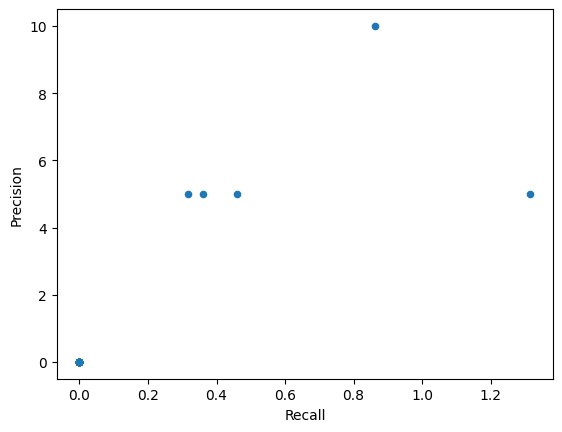

In [ ]:
output.plot(x = 'Recall', y = 'Precision', kind = 'scatter')

2099.0
(1682, 1)


C:\Users\wypyc\AppData\Local\Temp\ipykernel_3968\2254852572.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items_clustered['cluster'] = 1


      rating  movie_id  cluster
0     1416.0         1        1
1      355.0         2        1
2      235.0         3        1
...      ...       ...      ...
1676     3.0      1677        1
1680     3.0      1681        1
1681     3.0      1682        1

[1633 rows x 3 columns]
aaa 1


<Axes: xlabel='Recall', ylabel='Precision'>

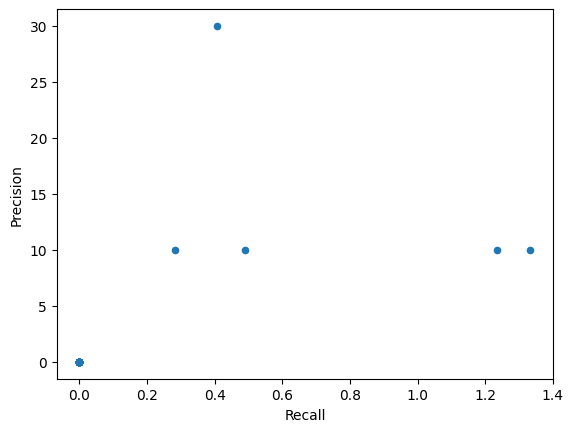

In [ ]:
Ioutput = nazwepozniej(test_set, train_set, 0, 10)
Ioutput.plot(x = 'Recall',y = 'Precision', kind = 'scatter')

In [ ]:
Ioutput

movie_id,50,100,127,174,181,258,topN_movies,Hu,NDCG,Precision,Recall
user_id,,,,,,,,,,,
3,110.333333,121.929274,131.602854,126.476395,122.647936,107.938064,"[127, 174, 181, 100, 50, 258]","[181, 245, 258, 260, 264, 268, 271, 272, 288, ...",0.033909,20.0,3.703704
4,110.333333,121.929274,131.602854,126.476395,122.647936,107.938064,"[127, 174, 181, 100, 50, 258]","[11, 50, 210, 258, 260, 264, 271, 288, 294, 30...",0.029428,20.0,8.333333
9,35.448276,34.256492,32.921693,36.311342,42.207039,42.466967,"[258, 181, 174, 50, 100, 127]","[6, 7, 50, 201, 242, 276, 286, 294, 298, 340, ...",0.017056,10.0,4.545455
...,...,...,...,...,...,...,...,...,...,...,...
927,110.333333,121.929274,131.602854,126.476395,122.647936,107.938064,"[127, 174, 181, 100, 50, 258]","[1, 7, 8, 11, 15, 24, 25, 28, 29, 38, 41, 56, ...",0.024987,10.0,0.833333
942,57.793103,53.130821,55.240664,56.754725,61.539484,55.925144,"[181, 50, 174, 258, 127, 100]","[31, 50, 71, 79, 95, 97, 99, 117, 124, 131, 13...",0.061845,30.0,3.797468
943,35.448276,34.256492,32.921693,36.311342,42.207039,42.466967,"[258, 181, 174, 50, 100, 127]","[2, 9, 11, 12, 22, 23, 24, 27, 28, 31, 38, 41,...",0.091272,50.0,2.976190


# przykład z artykułu

In [ ]:
article = pd.read_csv(Path('..','..','res','data','article.csv'))
article

,user_id,movie_id,rating,timestamp,cluster
0,1,1,3,77,1
1,1,2,4,77,1
2,1,3,0,77,1
...,...,...,...,...,...
32,5,5,0,77,1
33,5,6,0,77,1
34,5,7,0,77,1


In [ ]:
article_matrix = article.pivot(index = 'user_id', columns = 'movie_id', values = 'rating')
article_matrix

movie_id,1,2,3,4,5,6,7
user_id,,,,,,,
1,3,4,0,5,2,0,0
2,0,5,5,4,0,3,3
3,2,3,3,0,2,4,3
4,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0


In [ ]:
def IP2(train_numpy, items_clustered):
    
    #obliczanie item popularity
    #szukanie IPmax
    IP = np.sum(train_numpy, axis = 0)
    IP = IP.reshape(1,-1)
    IPmax = np.amax(IP)
    IPmax_coordinates = np.argmax(IP) + 1 #bo filmy mają indeksy od 1
    
    #znalezienie clustra IPmax i należących do niego elementów
    IPmax_cluster = items_clustered[items_clustered['movie_id'] == IPmax_coordinates].iloc[0,4]
    max_clust_movies = items_clustered[items_clustered['cluster'] == IPmax_cluster]['movie_id'].to_list()
    max_clust_movies = list(set(max_clust_movies))
    IP_dash = IP[:,np.array(max_clust_movies) - 1] / IPmax
    return(IP_dash, max_clust_movies)

def UP_HP2(train_set, cluster, clust_data, IP_dash, alpha, selected_movies):
    
    #znalezienie starych użytkowników w danym clustrze
    users_in_cluster = clust_data[clust_data['cluster'] == cluster]['user_id'].to_list()
    users_in_cluster = list(set(users_in_cluster))

    #macierz ratingów tylko dla tych userów
    dd = train_set[train_set.index.isin(users_in_cluster)]
    #ratings_matrix_cluster = train_set[train_set.index.isin(users_in_cluster)].to_numpy()
    ratings_matrix_cluster = train_set.loc[train_set.index.isin(users_in_cluster),selected_movies].to_numpy()

    #obliczanie user popularity
    UP = np.sum(ratings_matrix_cluster, axis=1) ##sumowanie po wierszach
    UP = UP.reshape(-1,1)
    UPmax = np.amax(UP)
    UPmax_coordinates = np.argmax(UP)
    UP_dash = UP / UPmax
    
    # obliczenie UIP i hybrydy
    UIP = UP_dash / IP_dash

    UIP = np.where(ratings_matrix_cluster == 0, 0, UIP)
    HP = alpha * IP_dash + (1-alpha) * np.sum(UIP,axis = 0).reshape(1,-1)
    
    return(HP)
    

In [ ]:
ip_res = IP2(article_matrix.to_numpy(), article)
pd.DataFrame(ip_res[0])

,0,1,2,3,4,5,6
0,0.416667,1.0,0.666667,0.75,0.333333,0.583333,0.5


In [ ]:
HP = UP_HP2(article_matrix, 1, article, ip_res[0], 0.5, [1,2,3,4,5,6,7])
pd.DataFrame(HP)

,0,1,2,3,4,5,6
0,2.068333,1.775,1.720833,1.508333,2.491667,1.877381,2.1


In [ ]:
9,11,17


(9, 11, 17)

In [ ]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

# Wygeneruj przykładowe dane
data = np.array([2, 3, 5, 8, 10, 12, 18, 20])

# Zdefiniuj parametry klastrów
num_clusters = 2
m = 2.0  # stopień rozmycia

# Wykonaj fuzzy k-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data, num_clusters, m, error=0.005, maxiter=1000, init=None)

# Przyporządkuj punkty danych do klastrów
cluster_membership = np.argmax(u, axis=0)

IndexError: tuple index out of range

In [ ]:
cldf = pd.read_csv(Path('..','..','outputs','items_train_clustered.csv'))

In [ ]:
cldf['cluster'] = 1

In [ ]:
cldf.to_csv(Path('..','..','outputs','jeden_cluster.csv'), index=False)